In [49]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.metrics import edit_distance
from transformers import AutoTokenizer

random.seed(6)
np.random.seed(6)


# Experiment 6 - MCQ Long answer HTML tags

For this experiment I changed the system prompt, asking the LLM to generate more text (about "thinking") and then give the final answer.


**Parameters:**
- system prompt: MCQ_system_prompt_v3.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [50]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


Loading the responses from the LLM

In [51]:
# needed to modify the output file because of the bug
# I introduced in the code
predictions = []
with open('../outputs/responses_llama3.2_20250210_20:17:23.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,<Reasoning> To determine which object was tidi...
Interaction_T1_14,<Reasoning> To determine which object was tidi...
Interaction_T1_31,Error while generating the response. Look at t...
Interaction_T1_32,<Reasoning> To determine which object was put ...
Interaction_T1_40,<Reasoning> The question asks which object was...
...,...
Feasibility_T6_1453,<Reasoning> To determine what the person is ab...
Feasibility_T6_1454,"<Reasoning> To answer this question, we need t..."
Feasibility_T6_1455,"<Reasoning> To answer this question, we need t..."


In [52]:
predictions_df.iloc[0:20]['answer'].apply(print)


<Reasoning>
To determine which object was tidied up by the person, we need to analyze the sequence of events unfolding in the frames. 

The first two Scene-Graphs show the person standing next to the clothes and then in front of the clothes. This suggests that the person is picking up or arranging the clothes.

In the subsequent Scene-Graphs, the person's relationship with the blanket changes from being on the side to being in front of it. However, this does not necessarily imply that the person is tidying up the blanket, as the person may be holding or touching it instead.

The key insight comes from the later Scene-Graphs, where the person is shown holding the clothes and then being in front of them again. This suggests a reversal of roles, with the person now holding the clothes rather than picking them up.

Therefore, based on this analysis, we can conclude that the object tidied up by the person is actually the clothes.
</Reasoning>

<Final answer>
A: 2. The clothes.
</Final answe

id
Interaction_T1_13     None
Interaction_T1_14     None
Interaction_T1_31     None
Interaction_T1_32     None
Interaction_T1_40     None
Interaction_T1_43     None
Interaction_T1_70     None
Interaction_T1_71     None
Interaction_T1_76     None
Interaction_T1_78     None
Interaction_T1_81     None
Interaction_T1_95     None
Interaction_T1_100    None
Interaction_T1_101    None
Interaction_T1_104    None
Interaction_T1_106    None
Interaction_T1_111    None
Interaction_T1_137    None
Interaction_T1_139    None
Interaction_T1_147    None
Name: answer, dtype: object

In [53]:
# Check if the the template is somewhere in the answer
html_tags_pattern = r'<Final answer>\s*A:\s*\d\.\s*((?:\w+(?:\s|\/)?){,10}\.)\s*</Final answer>'
html_tags_mask = predictions_df['answer'].str.contains(html_tags_pattern, case=False, regex=True)


print(f"Answer following the template: {html_tags_mask.value_counts()[True]}\n"
      f"{html_tags_mask.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {html_tags_mask.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 2100
29.59% of the total

Only 4998 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_302025/447578442.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  html_tags_mask = predictions_df['answer'].str.contains(html_tags_pattern, case=False, regex=True)


Let's start by viewing how many answers follow the template:

In [54]:
# Check if the the template is somewhere in the answer
#
# An example of the template expressed by the regex is: A: 1. The answer.
# where the number followed by a dot is optional
ans_regex_pattern = r'A:\s*(?:\d\.)?\s*((?:\w+(?:\s|\/)?){,10}\.)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


/tmp/ipykernel_302025/2545864474.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


Answer following the template: 6900
97.21% of the total

Only 198 samples do not contain the answer in the response with the specified format


In [55]:
# Check that contains answer is subset of html_tags
assert (html_tags_mask & contains_answer).sum() == html_tags_mask.sum()


## Non-conforming responses

In [56]:
predictions_df.loc[~html_tags_mask].iloc[:5]['answer'].apply(lambda x: print(x, '\n\n'))


<Reasoning>
To determine which object was tidied up by the person, we need to analyze the sequence of events unfolding in the frames.

From the given Spatio-Temporal Scene-Graphs, we can see that the person is holding a towel and clothes, and is in front of the towel and clothes. The person is also touching the towel and clothes. 

However, there is no direct relationship between the person and the blanket being tidied up. But, we notice that the person is on the side of the towel and blanket, which suggests that they might be holding or moving the blanket.

Looking at the alternatives provided, option 2: The clothes seems to be the most likely answer. We can see that the person is in front of the clothes multiple times, and there is a relationship between the person and the clothes being tidied up.

Therefore, based on the analysis of the sequence of events unfolding in the frames, I conclude that:

A: 2. The clothes. 


Error while generating the response. Look at the logs. 


<Reaso

id
Interaction_T1_14    None
Interaction_T1_31    None
Interaction_T1_32    None
Interaction_T1_40    None
Interaction_T1_43    None
Name: answer, dtype: object

In [57]:
predictions_df.loc[~contains_answer].iloc[:100]['answer'].apply(lambda x: print(x, '\n\n'))


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


<Reasoning>
To

id
Interaction_T1_31     None
Interaction_T1_70     None
Interaction_T1_76     None
Interaction_T1_148    None
Interaction_T1_173    None
                      ... 
Sequence_T1_1232      None
Sequence_T1_1246      None
Sequence_T1_1845      None
Sequence_T1_2125      None
Sequence_T1_2515      None
Name: answer, Length: 100, dtype: object

In [58]:
# Note: to access meta-llama you have to first accept the licence agreement
hugg_key = os.environ['HUGGINGFACE_KEY']

tokenizer = AutoTokenizer.from_pretrained(
                'meta-llama/Llama-3.2-3B-Instruct', 
                token=hugg_key)


In [59]:
resp_token_len = pd.Series(index=predictions_df.index)

for index, row in predictions_df.iterrows():
    resp_token_len.loc[index] = len(tokenizer.encode(row['answer']))

resp_token_len.sort_values().value_counts(sort=False)


/tmp/ipykernel_302025/4005420109.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  resp_token_len = pd.Series(index=predictions_df.index)


12.0      166
50.0        1
52.0        4
54.0        2
55.0        4
         ... 
6411.0      1
6641.0      1
7202.0      1
7547.0      1
7976.0      1
Length: 486, dtype: int64

The responses with a token length of 12 are those that caused an error during generation (mainly due to time-out 4mins):

In [60]:
(predictions_df[resp_token_len == 12] == "Error while generating the response. Look at the logs.").all()


answer    True
dtype: bool

In [61]:

print(f"Number of responses that are not conformat to the regex: {predictions_df[~contains_answer].shape[0]}")
print(f"Number of responses that took too long to answer:        {(resp_token_len == 12).sum()}")


Number of responses that are not conformat to the regex: 198
Number of responses that took too long to answer:        166


In [62]:
predictions_df[(~contains_answer) & ~(resp_token_len == 12)]['answer'].apply(lambda x: print(x, '\n\n'))


<Reasoning>
To determine which object was opened by the person, we need to analyze the Scene-Graphs and identify the relationships between the person and other objects.

From the given Spatio-Temporal Scene-Graph, we can see that in multiple frames, the person is touching or holding a book. However, there is no direct relationship between the person and an object being opened (e.g., "person - opening - book").

But, if we look closely at one of the frames, ['person - in_front_of - table', 'person - touching - book', 'person - in_front_of - book'], it seems that the person is touching a book on a table. This could imply that the person is holding or manipulating the book.

However, another frame, ['person - in_front_of - table', 'person - holding - book', 'person - in_front_of - book'], explicitly shows the person holding a book. 

Considering these observations, it seems that the most likely object to be opened by the person is not directly stated in the Scene-Graphs. However, given th

id
Interaction_T1_3112    None
Interaction_T1_5726    None
Interaction_T1_5891    None
Interaction_T1_7203    None
Interaction_T1_9091    None
Interaction_T2_3509    None
Interaction_T2_7213    None
Interaction_T3_1423    None
Interaction_T3_4060    None
Interaction_T3_5887    None
Interaction_T3_6051    None
Interaction_T4_1751    None
Interaction_T4_2794    None
Interaction_T4_2867    None
Interaction_T4_2944    None
Sequence_T1_2615       None
Sequence_T1_3516       None
Sequence_T3_231        None
Sequence_T3_1632       None
Sequence_T3_6283       None
Sequence_T4_811        None
Sequence_T4_2030       None
Sequence_T4_4192       None
Sequence_T4_4232       None
Sequence_T5_3779       None
Sequence_T5_4329       None
Sequence_T5_4362       None
Sequence_T5_6552       None
Sequence_T6_494        None
Sequence_T6_1638       None
Feasibility_T3_78      None
Feasibility_T6_848     None
Name: answer, dtype: object

## Distribution of generated response lengths measured in tokens

count    7098.000000
mean      222.866582
std       253.043206
min        12.000000
25%       166.000000
50%       204.000000
75%       251.000000
max      7976.000000
dtype: float64

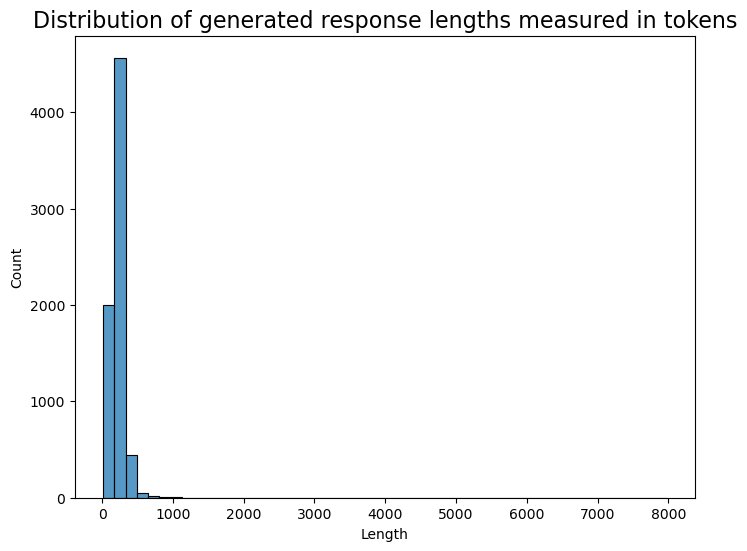

In [63]:
plt.figure(figsize=(8, 6))
sns.histplot(resp_token_len, bins=50)
plt.title("Distribution of generated response lengths measured in tokens", fontsize=16)
plt.xlabel("Length")
plt.ylabel("Count")

resp_token_len.describe()


## Extracting the answers

Let's extract the the answers from the generated texts which do contain an answer:

In [64]:
ans_df = predictions_df.loc[contains_answer]['answer'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The clothes.
Interaction_T1_14,The clothes.
Interaction_T1_32,The shoe.
Interaction_T1_40,The blanket.
Interaction_T1_43,The clothes.
...,...
Feasibility_T6_1453,Wash the table.
Feasibility_T6_1454,Wipe the table.
Feasibility_T6_1455,Take the shoe.


In [65]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 518 unique answers


In [66]:
ans_df['text'].value_counts()


Took.                                          344
Put down.                                      329
Tidied up.                                     273
The towel.                                     268
The clothes.                                   258
                                              ... 
Eat the food.                                    1
Opened the box is not a likely explanation.      1
The person was touching the refrigerator.        1
Put down the window.                             1
Wipe the table.                                  1
Name: text, Length: 259, dtype: Int64

<AxesSubplot: xlabel='freq', ylabel='word'>

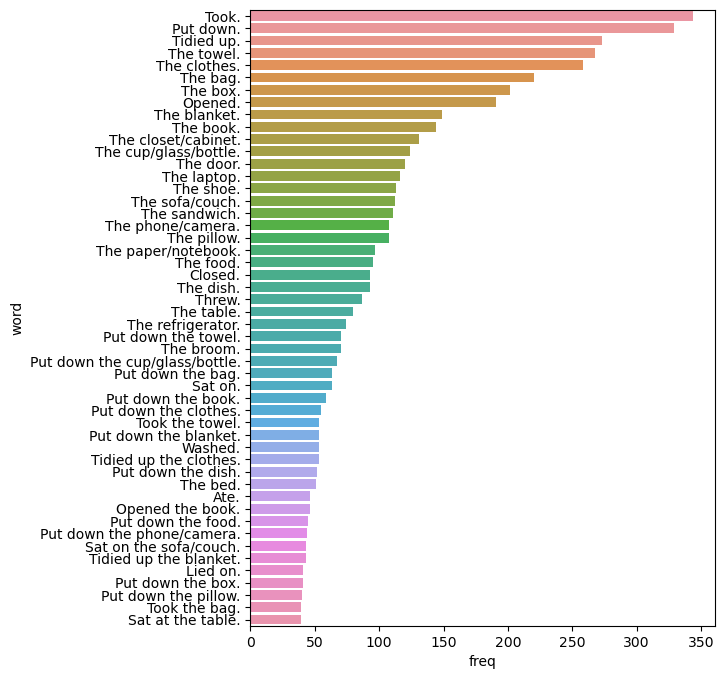

In [67]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [68]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


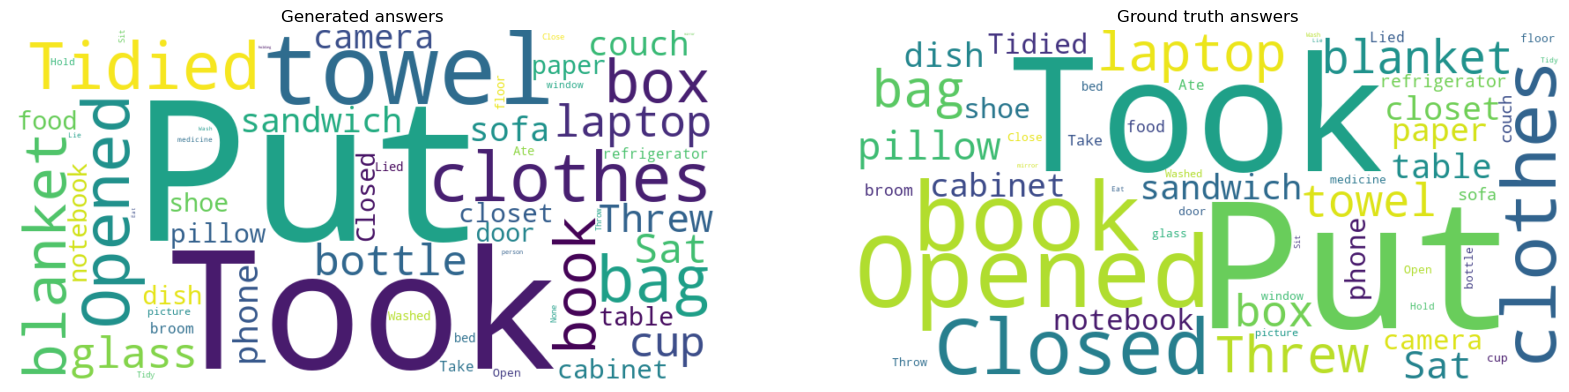

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(ans_df['text'].astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_df['text'].astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


<AxesSubplot: xlabel='freq', ylabel='word'>

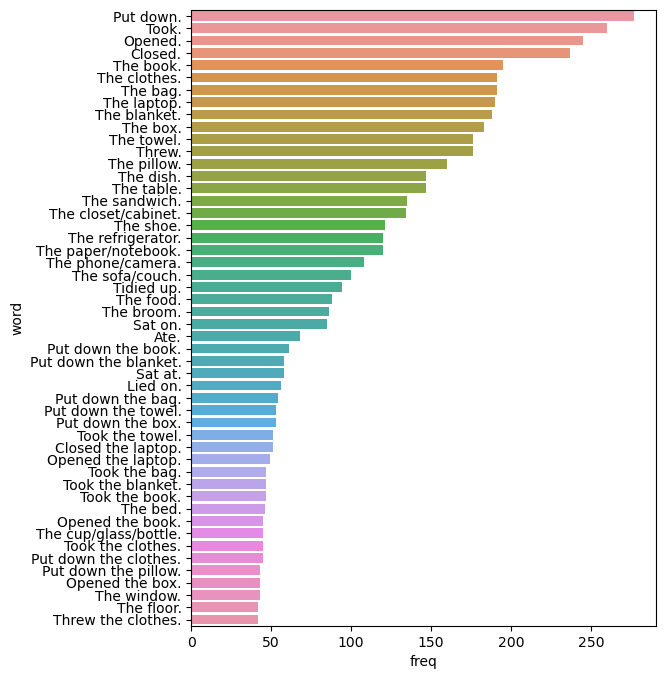

In [70]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [71]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(6900, 4)

In [72]:
eval_df['edit_distance'] = eval_df.apply(func=lambda row: edit_distance(row['text'], row['pred_text']), axis=1)

eval_df['edit_distance'].sort_values(ascending=True).value_counts(sort=False)


0     3038
1        2
2       57
3       58
4      452
5      435
6      341
7      676
8      469
9       96
10     175
11     187
12     203
13     198
14     132
15      98
16      44
17      44
18      43
19      50
20      31
21      22
22      25
23       5
24       1
25       1
26       1
27       1
28       2
30       3
32       3
35       1
37       1
40       1
41       1
53       1
55       1
60       1
Name: edit_distance, dtype: int64

In [73]:
eval_df[(eval_df['edit_distance'] > 0) & (eval_df['edit_distance'] < 3)]


,choices,num,text,pred_text,edit_distance
id,,,,,
Interaction_T1_526,"{'0': 'The book.', '1': 'The bag.', '2': 'The ...",0,The book.,The door.,2
Interaction_T1_1219,"{'0': 'The door.', '1': 'The book.', '2': 'The...",0,The door.,The book.,2
Interaction_T1_1246,"{'0': 'The box.', '1': 'The broom.', '2': 'The...",0,The box.,The bag.,2
Interaction_T1_1249,"{'0': 'The book.', '1': 'The door.', '2': 'The...",0,The book.,The door.,2
Interaction_T1_1300,"{'0': 'The bag.', '1': 'The box.', '2': 'The b...",0,The bag.,The box.,2
Interaction_T1_1826,"{'0': 'The window.', '1': 'The book.', '2': 'T...",1,The book.,The box.,2
Interaction_T1_2695,"{'0': 'The box.', '1': 'The bag.', '2': 'The p...",1,The bag.,The box.,2
Interaction_T1_2941,"{'0': 'The book.', '1': 'The broom.', '2': 'Th...",0,The book.,The broom.,2
Interaction_T1_4496,"{'0': 'The bag.', '1': 'The box.', '2': 'The b...",0,The bag.,The box.,2


In [74]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'] == eval_df[on_what]).sum()
    

    return hits_text/eval_df.shape[0]


In [75]:
text_acc = accuracy(eval_df)

print(f"Text Accuracy: {text_acc:.2%}")


Text Accuracy: 44.03%


In [76]:
eval_df[eval_df['text'] == eval_df['pred_text']]


,choices,num,text,pred_text,edit_distance
id,,,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.,The clothes.,0
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.,The clothes.,0
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,The shoe.,0
Interaction_T1_43,"{'0': 'The box.', '1': 'The pillow.', '2': 'Th...",3,The clothes.,The clothes.,0
Interaction_T1_81,"{'0': 'The bed.', '1': 'The sofa/couch.', '2':...",1,The sofa/couch.,The sofa/couch.,0
...,...,...,...,...,...
Feasibility_T6_1428,"{'0': 'Close the refrigerator.', '1': 'Throw t...",3,Take the cup/glass/bottle.,Take the cup/glass/bottle.,0
Feasibility_T6_1448,"{'0': 'Put down the laptop.', '1': 'Tidy up th...",0,Put down the laptop.,Put down the laptop.,0
Feasibility_T6_1449,"{'0': 'Throw the towel.', '1': 'Close the refr...",2,Put down the laptop.,Put down the laptop.,0


check if the equality with NA result in a false or is skipped

In [77]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 42.80%


In [78]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [79]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2308        43.93%  
Sequence            3485        44.33%  
Prediction           621        42.67%  
Feasibility          486        44.03%  


In [80]:
index_intersect = predictions_df[html_tags_mask].index.intersection(eval_df.index)
print_acc(eval_df.loc[index_intersect], accuracy)


Question type       Total      Accuracy 

Interaction          586        47.44%  
Sequence            1068        48.03%  
Prediction           258        44.19%  
Feasibility          188        46.81%  


In [81]:
# % of answers conforming to the template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        96.25%  
Sequence            3586        97.18%  
Prediction           624        99.52%  
Feasibility          490        99.18%  
Overall             7098        97.21%  


In [82]:
exact_match_mask = eval_df['text'] == eval_df['pred_text']


In [87]:
in_choices_mask = eval_df[contains_answer].apply(lambda x: x['pred_text'] in list(x['choices'].values()), axis=1)
in_choices_mask.value_counts()


/tmp/ipykernel_302025/1150264334.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  in_choices_mask = eval_df[contains_answer].apply(lambda x: x['pred_text'] in list(x['choices'].values()), axis=1)


True     6696
False     204
dtype: int64

198

In [106]:
uniques = list(gt_df['text'].unique())

in_gt = eval_df[contains_answer].apply(lambda x: x['pred_text'] in uniques, axis=1)
in_gt.value_counts()


/tmp/ipykernel_302025/1930248972.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  in_gt = eval_df[contains_answer].apply(lambda x: x['pred_text'] in uniques, axis=1)


True     6761
False     139
dtype: int64

In [119]:
for _, row in eval_df.loc[~in_gt][['text', 'pred_text']].iterrows():
    print(f"{row['text']:<50}{row['pred_text']:<50}")


The dish.                                         None of the above.                                
The bag.                                          None of the above.                                
The bag.                                          None of the above.                                
The medicine.                                     0.                                                
The shoe.                                         The shoes.                                        
The pillow.                                       2.                                                
The phone/camera.                                 None of the above.                                
The blanket.                                      None of the above.                                
The book.                                         None of the above.                                
The refrigerator.                                 None of the above.                       

In [110]:
(eval_df['pred_text'] == 'None of the above.').sum()


30

In [98]:
(~in_choices_mask & ~exact_match_mask).sum() == (~in_choices_mask).sum()


True

In [91]:
eval_df[~in_choices_mask & ~exact_match_mask]


,choices,num,text,pred_text,edit_distance
id,,,,,
Interaction_T1_71,"{'0': 'The paper/notebook.', '1': 'The clothes...",0,The paper/notebook.,The shoe.,12
Interaction_T1_375,"{'0': 'The phone/camera.', '1': 'The food.', '...",2,The blanket.,The clothes.,5
Interaction_T1_522,"{'0': 'The shoe.', '1': 'The broom.', '2': 'Th...",3,The book.,The paper/notebook.,10
Interaction_T1_711,"{'0': 'The laptop.', '1': 'The book.', '2': 'T...",1,The book.,The blanket.,5
Interaction_T1_1126,"{'0': 'The book.', '1': 'The food.', '2': 'The...",3,The dish.,The towel.,5
...,...,...,...,...,...
Feasibility_T5_2398,"{'0': 'The paper/notebook.', '1': 'The laptop....",1,The laptop.,The towel.,6
Feasibility_T6_494,"{'0': 'Put down the laptop.', '1': 'Put down t...",3,Hold the phone/camera.,Put down the cup/glass/bottle.,21
Feasibility_T6_720,"{'0': 'Close the door.', '1': 'Hold the clothe...",2,Open the bag.,The clothes.,10


In [84]:
eval_df.loc[~exact_match_mask][['text', 'pred_text']]


,text,pred_text
id,,
Interaction_T1_40,The closet/cabinet.,The blanket.
Interaction_T1_71,The paper/notebook.,The shoe.
Interaction_T1_78,The laptop.,The refrigerator.
Interaction_T1_95,The dish.,The clothes.
Interaction_T1_100,The blanket.,The clothes.
...,...,...
Feasibility_T6_1414,Open the book.,Throw the bag.
Feasibility_T6_1430,Wash the dish.,Take the pillow.
Feasibility_T6_1454,Take the towel.,Wipe the table.
